In [371]:
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly

import catboost as cb
import optuna
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.WARNING)

import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score, roc_auc_score, f1_score, fbeta_score, roc_curve, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from yellowbrick.classifier import ROCAUC
from yellowbrick.contrib.wrapper import wrap


In [160]:
# seed everything

my_seed = 42

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(my_seed)

In [161]:
path = '/Users/sam/Desktop/Data Science/Notebooks/Predicting Student Grades/'
file = 'student-grades.csv'

In [162]:
df = pd.read_csv(path + file)

df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [163]:
df.shape

(395, 33)

In [164]:
df.isnull().values.any()

False

In [165]:
df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


In [166]:
df.describe(include=[object])

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
count,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395
unique,2,2,2,2,2,5,5,4,3,2,2,2,2,2,2,2,2
top,GP,F,U,GT3,T,other,other,course,mother,no,yes,no,yes,yes,yes,yes,no
freq,349,208,307,281,354,141,217,145,273,344,242,214,201,314,375,329,263


# Feature Engineering

In [167]:
# create pass and fail column

df['pass'] = np.where(df['G3'] >= 10, 'pass', 'fail')

In [168]:
# create letter grade column

df.loc[df['G3'] < 10, 'Grade'] = 'F'
df.loc[(df['G3'] >= 10) & (df['G3'] <= 11), 'Grade'] = 'D'
df.loc[(df['G3'] >= 12) & (df['G3'] <= 13), 'Grade'] = 'C'
df.loc[(df['G3'] >= 14) & (df['G3'] <= 15), 'Grade'] = 'B'
df.loc[df['G3'] >= 16, 'Grade'] = 'A'

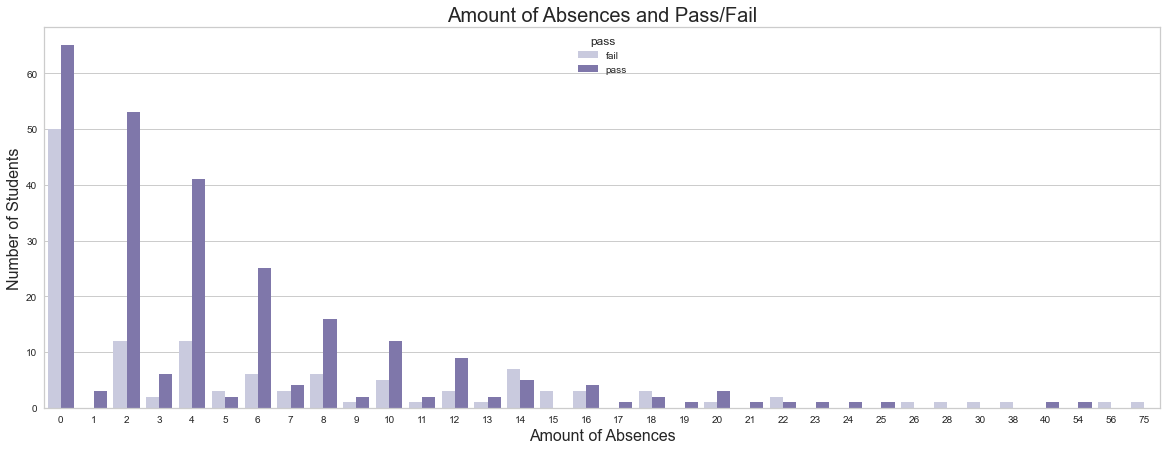

In [169]:
# plot absences vs pass/fail

fig = plt.figure(figsize=(20, 7))

study = sns.countplot(data=df, x="absences", hue="pass", palette='Purples')

plt.title('Amount of Absences and Pass/Fail', fontsize=20)
plt.xlabel('Amount of Absences', fontsize=16)
plt.ylabel('Number of Students', fontsize=16)

plt.show()

In [170]:
# binning the days

df['absences'] = df['absences'].replace([1, 3, 5, 7, 9, 11 ,13, 15, 17, 19, 21, 23, 25],
                       [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26])

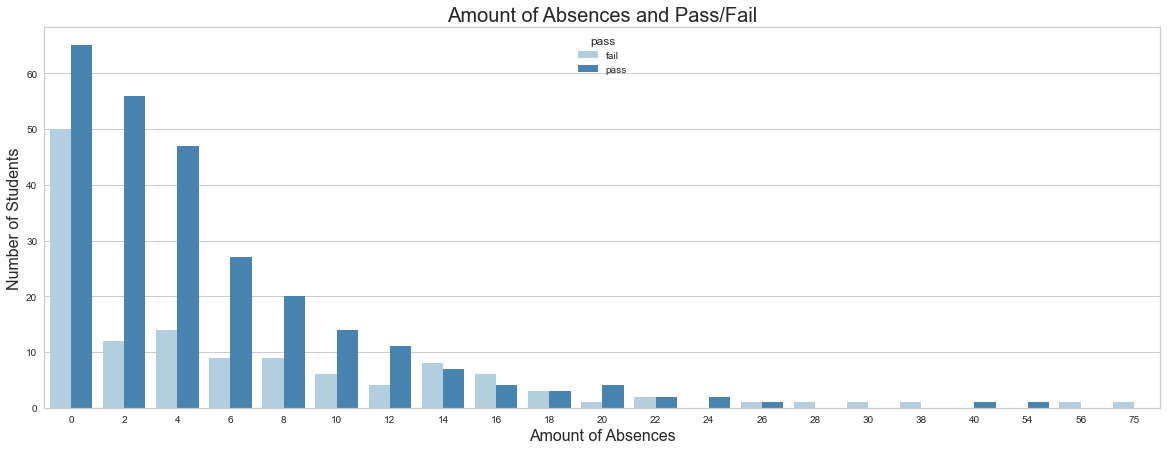

In [171]:
# plot absences vs pass/fail

fig = plt.figure(figsize=(20, 7))

study = sns.countplot(data=df, x="absences", hue="pass", palette='Blues')

plt.title('Amount of Absences and Pass/Fail', fontsize=20)
plt.xlabel('Amount of Absences', fontsize=16)
plt.ylabel('Number of Students', fontsize=16)

plt.show()

In [172]:
# manually encoding pass column

fmap = {'pass':1, 'fail':0}

# apply filter to pass column

df['pass'] = df['pass'].map(fmap)

In [173]:
# manually encoding all yes/no variables to ensure yes=1 no=0

fmap = {'yes':1, 'no':0}

df['schoolsup'] = df['schoolsup'].map(fmap)
df['famsup'] = df['famsup'].map(fmap)
df['paid'] = df['paid'].map(fmap)
df['activities'] = df['activities'].map(fmap)
df['nursery'] = df['nursery'].map(fmap)
df['higher'] = df['higher'].map(fmap)
df['internet'] = df['internet'].map(fmap)
df['romantic'] = df['romantic'].map(fmap)

# 1) Regression Modeling (Number Grade)

## A) Modeling After the Second Trimester (G1, G2) for Final Grade (G3)

In [174]:
train_df , test_df = train_test_split(df, test_size=0.2, random_state=my_seed, stratify=df['Grade'])

In [175]:
train_df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3', 'pass', 'Grade'],
      dtype='object')

In [176]:
features = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
           'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
           'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
           'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
           'Walc', 'health', 'absences', 'G1', 'G2']
target = ['G3']

In [177]:
train_features = train_df[features]
train_target = train_df[target]

test_features = test_df[features]
test_target = test_df[target]

In [178]:
categorical_features_indices = [0, 1, 3, 4, 5, 8, 9, 10, 11]

In [179]:
def objective(trial):

    train_x, valid_x, train_y, valid_y = train_test_split(train_features, train_target, test_size=0.3, stratify=train_df['Grade'])

    train_pool = cb.Pool(train_x, train_y, cat_features=categorical_features_indices)
    valid_pool = cb.Pool(valid_x, valid_y, cat_features=categorical_features_indices)

    params = {
                     "loss_function": trial.suggest_categorical("loss_function", ["RMSE", "MAE"]),
                     'od_wait': trial.suggest_int('od_wait', 10, 50, step=1),
                     "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.99),
                     "random_strength": trial.suggest_int("random_strength", 1, 10, step=1),
                     "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 50.0),
                     "max_depth": trial.suggest_int("max_depth", 2, 10, step=1),
                     "n_estimators": trial.suggest_int("n_estimators", 100, 2500, step=1),
                     'learning_rate': trial.suggest_loguniform("learning_rate", 0.005, 0.1),
                     "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
                    "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
                    "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
                    "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 10),
                    }

    # Conditional Hyper-Parameters
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)
    elif params["bootstrap_type"] == "MVS":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)

    cbreg_model = cb.CatBoostRegressor(**params, random_state=my_seed)

    cb_optuna = cbreg_model.fit(train_pool, eval_set=valid_pool, verbose=False, early_stopping_rounds=100)

    preds = cb_optuna.predict(valid_x)

    MAE = mean_absolute_error(valid_y, preds)

    print('MAE score of CatBoost =', MAE)

    return MAE

In [180]:
study = optuna.create_study(direction="minimize", sampler = TPESampler(seed=my_seed), study_name="Trimester 2 Regression")
study.optimize(objective, n_trials=100, n_jobs=-1)

/Users/sam/.conda/envs/env_two/lib/python3.9/site-packages/optuna/study/study.py:393: FutureWarning:

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost =MAE score of CatBoost = 1.2298233921530557
 1.2666946491034554
MAE score of CatBoost = 2.6562750278232192


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost = 0.9555035968956764
MAE score of CatBoost = 1.7444940883212963
MAE score of CatBoost = 1.7931566698552905
MAE score of CatBoost = 1.648422939132319
MAE score of CatBoost = 1.122707999915613
MAE score of CatBoost = 1.282507228625973
MAE score of CatBoost = 1.5918285953274725
MAE score of CatBoost = 1.3613913525895271
MAE score of CatBoost = 1.321824951829002
MAE score of CatBoost =MAE score of CatBoost = 1.3176322987076727 MAE score of CatBoost =
1.3204630318823356 1.445629974635095



Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost = 1.2175585665204771
MAE score of CatBoost = 1.6675294400817233
MAE score of CatBoost = 1.2497659802351337
MAE score of CatBoost = 1.2109345021473172


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost = 1.3566573124875312
MAE score of CatBoost = 1.0852147401042842
MAE score of CatBoost = 1.5570929038082664
MAE score of CatBoost = 1.4266828148491126
MAE score of CatBoost = 1.206471823703965
MAE score of CatBoost = 1.2151044209009438
MAE score of CatBoost = 1.1621315306612139
MAE score of CatBoost = 1.2661616027766753
MAE score of CatBoost = 1.5491271972057057
MAE score of CatBoost = 1.5178274913044265
MAE score of CatBoost = 1.0091250447166744
MAE score of CatBoost = 1.060686867059895
MAE score of CatBoost = 1.1540627172176485


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost = 1.3307941800234557
MAE score of CatBoost = 1.2349881699807486
MAE score of CatBoost = 1.1734527386802813


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost = 1.393785046019238
MAE score of CatBoost = 1.1412829016190813
MAE score of CatBoost = 1.8380306757368994
MAE score of CatBoost = 1.4399299205215437
MAE score of CatBoost = 1.2948915190935673
MAE score of CatBoost = 1.273424632432757
MAE score of CatBoost = 1.4422977699810904
MAE score of CatBoost = 1.336653393431937
MAE score of CatBoost = 1.4103184812861123
MAE score of CatBoost = 1.190565803328985
MAE score of CatBoost = 1.3445752024829956
MAE score of CatBoost = 1.3599846171549819
MAE score of CatBoost = 1.421438867645497
MAE score of CatBoost = 1.8160533764310753
MAE score of CatBoost = 1.4554835769019387
MAE score of CatBoost = 1.4364933575165633
MAE score of CatBoost = 1.3527358914217658
MAE score of CatBoost = 1.2146982276382539
MAE score of CatBoost = 1.5596489577930281
MAE score of CatBoost = 1.3638889060627946


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost = 1.2047475915401968
MAE score of CatBoost = 1.2506094702733712


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost = 1.2828024133152989
MAE score of CatBoost = 1.2737859164819014
MAE score of CatBoost = 1.1035231835145156
MAE score of CatBoost = 0.9455693661938541


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost = 1.1421946528966067
MAE score of CatBoost = 1.6377394511541408
MAE score of CatBoost = 1.0271540996413837
MAE score of CatBoost = 1.0040851495514838


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost = 1.3744071593962477
MAE score of CatBoost = 1.1342735414858935
MAE score of CatBoost = 1.2082735419820219
MAE score of CatBoost = 1.1760671179983113
MAE score of CatBoost = 0.9576733631218791


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost = 1.2924637352646697
MAE score of CatBoost = 1.4443178315285004


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost = 1.241614238995649
MAE score of CatBoost = 1.3403744488564098


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost = 1.5321059859182578
MAE score of CatBoost = 1.1317666959123913
MAE score of CatBoost = 1.0833529333321812
MAE score of CatBoost = 1.3336384364180796


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost =MAE score of CatBoost = 1.2264237489748413
 1.3113564709285865
MAE score of CatBoost = 1.2836471347311194
MAE score of CatBoost = 1.2166509246241106


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost = 1.0117060528152846
MAE score of CatBoost = 1.1300736240086813
MAE score of CatBoost = 1.2410358493820057
MAE score of CatBoost = 1.298992911785415


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost = 1.1823729846752604
MAE score of CatBoost = 1.051380319557213
MAE score of CatBoost = 1.0939363558619375


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost = 1.320470674523077
MAE score of CatBoost = 1.4863801209143814
MAE score of CatBoost = 1.5614708283327086


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost = 1.2639543263925777
MAE score of CatBoost = 1.132095420957256
MAE score of CatBoost = 1.360947917512917
MAE score of CatBoost = 1.2955834692086698
MAE score of CatBoost = 1.4376389083475403
MAE score of CatBoost = 1.2450230831030695
MAE score of CatBoost = 1.7756543462227419
MAE score of CatBoost = 1.4253575123686613


In [181]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.9455693661938541
  Params: 
    loss_function: MAE
    od_wait: 36
    colsample_bylevel: 0.7428728841170582
    random_strength: 4
    l2_leaf_reg: 6.347374337199513
    max_depth: 3
    n_estimators: 1143
    learning_rate: 0.07128961707548563
    min_data_in_leaf: 12
    boosting_type: Ordered
    bootstrap_type: MVS
    one_hot_max_size: 3
    subsample: 0.67051290686583


In [182]:
optuna.visualization.plot_optimization_history(study)

In [183]:

optuna.visualization.plot_param_importances(study)

In [185]:
optuna.visualization.plot_slice(study, params=['colsample_bylevel','max_depth', 'learning_rate' ,'random_strength', 'n_estimators'])

In [186]:
best_model = cb.CatBoostRegressor()
best_model = best_model.set_params(**study.best_params)
best_model = best_model.fit(train_features, train_target, cat_features= categorical_features_indices, verbose=False, early_stopping_rounds=100)

preds = best_model.predict(test_features)

MAE = mean_absolute_error(test_target, preds)

print('MAE score of CatBoost =', MAE)

MAE score of CatBoost = 0.9188652517557915


In [187]:
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,G2,51.174884
1,G1,18.569204
2,absences,4.392137
3,failures,3.738560
4,Fjob,3.156704
5,Mjob,3.116013
6,reason,1.965661
7,famrel,1.775526
8,age,1.460116
9,Walc,1.286621


In [188]:
shap_pool = cb.Pool(train_features, train_target, cat_features=categorical_features_indices)

shap_values = best_model.get_feature_importance(shap_pool, type='ShapValues')
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
print(shap_values.shape)

(316, 32)


In [189]:
shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], train_features.iloc[3,:])

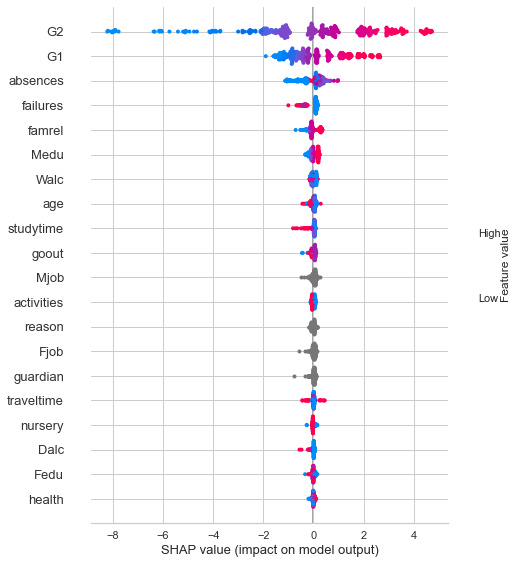

In [190]:
shap.summary_plot(shap_values, train_features)

In [191]:
x_small = train_features.iloc[0:200]
shap_small = shap_values[:200]
shap.force_plot(expected_value, shap_small, x_small)

## B) Modeling After the First Trimester (G1) for Final Grade (G3)

In [192]:
features = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
           'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
           'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
           'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
           'Walc', 'health', 'absences', 'G1']
target = ['G3']

In [193]:
train_features = train_df[features]
train_target = train_df[target]

test_features = test_df[features]
test_target = test_df[target]

In [194]:
categorical_features_indices = [0, 1, 3, 4, 5, 8, 9, 10, 11]

In [195]:
def objective(trial):

    train_x, valid_x, train_y, valid_y = train_test_split(train_features, train_target, test_size=0.3, stratify=train_df['Grade'])

    train_pool = cb.Pool(train_x, train_y, cat_features=categorical_features_indices)
    valid_pool = cb.Pool(valid_x, valid_y, cat_features=categorical_features_indices)

    params = {
                     "loss_function": trial.suggest_categorical("loss_function", ["RMSE", "MAE"]),
                     'od_wait': trial.suggest_int('od_wait', 10, 50, step=1),
                     "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.99),
                     "random_strength": trial.suggest_int("random_strength", 1, 10, step=1),
                     "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 50.0),
                     "max_depth": trial.suggest_int("max_depth", 2, 10, step=1),
                     "n_estimators": trial.suggest_int("n_estimators", 100, 2500, step=1),
                     'learning_rate': trial.suggest_loguniform("learning_rate", 0.005, 0.1),
                     "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
                    "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
                    "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
                    "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 10),
                    }

    # Conditional Hyper-Parameters
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)
    elif params["bootstrap_type"] == "MVS":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)

    cbreg_model = cb.CatBoostRegressor(**params, random_state=my_seed)

    cb_optuna = cbreg_model.fit(train_pool, eval_set=valid_pool, verbose=False, early_stopping_rounds=100)

    preds = cb_optuna.predict(valid_x)

    MAE = mean_absolute_error(valid_y, preds)

    print('MAE score of CatBoost =', MAE)

    return MAE

In [196]:
study = optuna.create_study(direction="minimize", sampler = TPESampler(seed=my_seed), study_name="Trimester 1 Regression")
study.optimize(objective, n_trials=100, n_jobs=-1)

/Users/sam/.conda/envs/env_two/lib/python3.9/site-packages/optuna/study/study.py:393: FutureWarning:

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost = 1.715563996117192
MAE score of CatBoost = 1.4156250550554412
MAE score of CatBoost = 2.251797812944332
MAE score of CatBoost = 2.6746213074945557
MAE score of CatBoost = 1.7331810797487348
MAE score of CatBoost = 2.272934816848223
MAE score of CatBoost = 1.8460662228085447


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost = 1.673308813986897
MAE score of CatBoost = 1.807464166055254


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost = 2.1817121082476594
MAE score of CatBoost = 1.788081266911473
MAE score of CatBoost = 2.1661142359319325


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost = 2.0114107241942887
MAE score of CatBoost = 1.7482626801371355
MAE score of CatBoost = 1.667319117064921
MAE score of CatBoost = 1.924309057017215
MAE score of CatBoost = 1.6751219667599277
MAE score of CatBoost = 1.5933943742076482
MAE score of CatBoost = 1.6553208201050875
MAE score of CatBoost = 2.114329085550694
MAE score of CatBoost = 1.6876416291031007
MAE score of CatBoost = 2.095846712428152
MAE score of CatBoost = 1.9572221239621708
MAE score of CatBoost = 1.9055037985624106
MAE score of CatBoost =MAE score of CatBoost = 1.3879803204139598
 2.30618314742996


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost = 2.184558491065261
MAE score of CatBoost = 1.8127321100213138


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost = 2.0659309794050573
MAE score of CatBoost = 1.6582667081245919
MAE score of CatBoost = 2.1588557062998652
MAE score of CatBoost = 1.8448899145000663
MAE score of CatBoost = 1.7375628186242618


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost = 1.762088473519036
MAE score of CatBoost = 1.5991431007501555
MAE score of CatBoost = 2.121194777041187
MAE score of CatBoost = 1.7050891559802686
MAE score of CatBoost = 1.7340974276272634
MAE score of CatBoost = 1.7395268628873373
MAE score of CatBoost =MAE score of CatBoost = 1.5653108535167055
 1.4502933095494204
MAE score of CatBoost = 1.6914162831676047


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost = 2.1249317567370327
MAE score of CatBoost = 1.9373921156045912
MAE score of CatBoost = 1.8274700027920385


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost = 1.5435171772736147
MAE score of CatBoost = 1.8727388909295901
MAE score of CatBoost = 2.0534822161479185


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost = 1.709913401107038
MAE score of CatBoost = 1.9025391076905485
MAE score of CatBoost = 1.8712658867838983
MAE score of CatBoost = 1.6767560329021713
MAE score of CatBoost = 1.8020804357405134
MAE score of CatBoost = 1.811963788102779


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost = 1.755582450124704
MAE score of CatBoost = 2.0741724277319893
MAE score of CatBoost = 1.6703497521792587
MAE score of CatBoost = 1.738827355505859
MAE score of CatBoost = 2.188666411019015
MAE score of CatBoost = 1.6958389064494854
MAE score of CatBoost =MAE score of CatBoost = 2.0048735606766583
 1.5193001291523245
MAE score of CatBoost = 1.5433627827535181


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost = 1.8594918590800997
MAE score of CatBoost = 1.653756076998779
MAE score of CatBoost = 1.4206169300084805
MAE score of CatBoost = 2.820357753878501
MAE score of CatBoost = 1.6978740616286365


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost = 3.373655804780568
MAE score of CatBoost = 2.037628617264817
MAE score of CatBoost = 1.8588608912727649
MAE score of CatBoost = 1.7463953295205488


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost = 2.1560394863430963
MAE score of CatBoost = 1.6415326674296657
MAE score of CatBoost = 1.7200547475506054
MAE score of CatBoost = 1.9655263213618663
MAE score of CatBoost = 1.6510960180634626
MAE score of CatBoost = 1.751427934238832
MAE score of CatBoost = 1.7902088761457144
MAE score of CatBoost = 1.611685624902181
MAE score of CatBoost = 2.07535663174744
MAE score of CatBoost = 1.9357249440431457
MAE score of CatBoost = 1.7552413958625346
MAE score of CatBoost = 1.7534030869298889
MAE score of CatBoost = 1.4936556146125368
MAE score of CatBoost = 1.6457094696358832
MAE score of CatBoost = 1.7324788607732293


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost = 1.726664723738246
MAE score of CatBoost = 1.5330475973312072
MAE score of CatBoost = 2.0724536887387535


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE score of CatBoost = 1.6223073558571526
MAE score of CatBoost = 1.8208252662699704
MAE score of CatBoost = 1.9156659118992507
MAE score of CatBoost = 1.680685685505957
MAE score of CatBoost = 1.5416577494763406
MAE score of CatBoost = 1.4910002372749371
MAE score of CatBoost = 1.8954980005131907
MAE score of CatBoost = 2.070499552086253
MAE score of CatBoost = 1.7858869837744646
MAE score of CatBoost = 1.8110235503776255


In [197]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 1.3879803204139598
  Params: 
    loss_function: RMSE
    od_wait: 35
    colsample_bylevel: 0.6842041763115043
    random_strength: 3
    l2_leaf_reg: 46.50888214806026
    max_depth: 3
    n_estimators: 2010
    learning_rate: 0.015397895544188788
    min_data_in_leaf: 19
    boosting_type: Ordered
    bootstrap_type: Bernoulli
    one_hot_max_size: 3
    subsample: 0.8408155198587712


In [198]:
optuna.visualization.plot_optimization_history(study)

In [200]:
best_model = cb.CatBoostRegressor()
best_model = best_model.set_params(**study.best_params)
best_model = best_model.fit(train_features, train_target, cat_features= categorical_features_indices, verbose=False, early_stopping_rounds=100)


preds = best_model.predict(test_features)

MAE = mean_absolute_error(test_target, preds)

print('MAE score of CatBoost =', MAE)

MAE score of CatBoost = 1.858722937611983


# 2) Classification Modeling (Pass/Fail)

## A) Modeling After the Second Trimester (G1, G2) for Pass/Fail

In [201]:
train_df , test_df = train_test_split(df, test_size=0.2, random_state=my_seed, stratify=df['failures'])

In [202]:
features = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
           'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
           'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
           'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
           'Walc', 'health', 'absences', 'G1', 'G2']
target = ['pass']

In [203]:
train_features = train_df[features]
train_target = train_df[target]

test_features = test_df[features]
test_target = test_df[target]

In [204]:
categorical_features_indices = [0, 1, 3, 4, 5, 8, 9, 10, 11]

In [205]:
def objective(trial):

    train_x, valid_x, train_y, valid_y = train_test_split(train_features, train_target, test_size=0.3, stratify=train_df['failures'])

    train_pool = cb.Pool(train_x, train_y, cat_features=categorical_features_indices)
    valid_pool = cb.Pool(valid_x, valid_y, cat_features=categorical_features_indices)

    params = {
        'iterations' : trial.suggest_int('iterations', 50, 300),
        'depth' : trial.suggest_int('depth', 2, 10),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])
    }

    # Conditional Hyper-Parameters
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)
    elif params["bootstrap_type"] == "MVS":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)

    cbclass_model = cb.CatBoostClassifier(**params, random_state=my_seed)

    cb2_optuna = cbclass_model.fit(train_pool, eval_set=valid_pool, verbose=False, early_stopping_rounds=100)

    preds = cb2_optuna.predict(valid_x)

    ROC_AUC_Score = roc_auc_score(valid_y, preds)

    print('ROC AUC Score of CatBoost =', ROC_AUC_Score)

    return ROC_AUC_Score

In [206]:
study = optuna.create_study(direction="maximize", sampler = TPESampler(seed=my_seed), study_name="Trimester 2 Classification")
study.optimize(objective, n_trials=100, n_jobs=-1)

/Users/sam/.conda/envs/env_two/lib/python3.9/site-packages/optuna/study/study.py:393: FutureWarning:

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost = 0.5
ROC AUC Score of CatBoost = 0.5
ROC AUC Score of CatBoost = 0.5740740740740741
ROC AUC Score of CatBoost = 0.8707810993249759
ROC AUC Score of CatBoost = 0.7182971014492754


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost = 0.926470588235294
ROC AUC Score of CatBoost = 0.8495660559305689
ROC AUC Score of CatBoost = 0.8814002089864159
ROC AUC Score of CatBoost = 0.5
ROC AUC Score of CatBoost = 0.6857675906183369


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost = 0.8588789682539683
ROC AUC Score of CatBoost = 0.9091151385927505


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost = 0.9000488758553276
ROC AUC Score of CatBoost = 0.9010263929618768


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost = 0.8692307692307693
ROC AUC Score of CatBoost = 0.717948717948718
ROC AUC Score of CatBoost = 0.9211309523809523
ROC AUC Score of CatBoost = 0.6696068548387097


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost = 0.6773809523809524
ROC AUC Score of CatBoost = 0.9221525600835947
ROC AUC Score of CatBoost =ROC AUC Score of CatBoost =  0.9278149386845038
0.9148987463837995
ROC AUC Score of CatBoost = 0.9448798328108673
ROC AUC Score of CatBoost = 0.9105461393596986


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost = 0.9115384615384616
ROC AUC Score of CatBoost = 0.8663194444444444
ROC AUC Score of CatBoost = ROC AUC Score of CatBoost = 0.8918918918918919
0.92984934086629
ROC AUC Score of CatBoost = 0.8642719382835102


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost = 0.8940914158305462
ROC AUC Score of CatBoost = 0.8797883064516129ROC AUC Score of CatBoost =
 ROC AUC Score of CatBoost =0.92984934086629
 0.868421052631579
ROC AUC Score of CatBoost = 0.9482570806100218
ROC AUC Score of CatBoost = 0.9217995169082126


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost = 0.8602564102564102
ROC AUC Score of CatBoost = 0.8464285714285714
ROC AUC Score of CatBoost = 0.9188453159041393
ROC AUC Score of CatBoost =ROC AUC Score of CatBoost = 0.8910068426197458
 0.9242857142857144
ROC AUC Score of CatBoost = 0.8665674603174602
ROC AUC Score of CatBoost = 0.9657142857142857


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost = 0.8611369990680336
ROC AUC Score of CatBoost =ROC AUC Score of CatBoost = 0.8356873822975519
 0.9081920903954802
ROC AUC Score of CatBoost = ROC AUC Score of CatBoost =0.8697458455522972
 0.9352142110762801
ROC AUC Score of CatBoost = 0.8779956427015251
ROC AUC Score of CatBoost = ROC AUC Score of CatBoost = 0.8596491228070176
0.8616813294232649


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost = 0.55
ROC AUC Score of CatBoost = 0.861904761904762
ROC AUC Score of CatBoost = 0.9291834677419355
ROC AUC Score of CatBoost = 0.912046370967742
ROC AUC Score of CatBoost = 0.8726190476190474
ROC AUC Score of CatBoost = 0.9367559523809523
ROC AUC Score of CatBoost = 0.8975694444444444
ROC AUC Score of CatBoost = 0.5889074693422519


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost = 0.904233870967742
ROC AUC Score of CatBoost = 0.9282051282051282
ROC AUC Score of CatBoost = ROC AUC Score of CatBoost = 0.8435897435897437
0.9057539682539683
ROC AUC Score of CatBoost = 0.8413693346190935
ROC AUC Score of CatBoost =ROC AUC Score of CatBoost = 0.932142857142857
 0.9522921108742004
ROC AUC Score of CatBoost = 0.9035714285714286


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost = 0.9213789682539683
ROC AUC Score of CatBoost = 0.8681732580037664


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost = 0.9095238095238095
ROC AUC Score of CatBoost = 0.9057539682539683
ROC AUC Score of CatBoost = 0.8979496738117427
ROC AUC Score of CatBoost = 0.8859649122807017


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost = 0.8702380952380953
ROC AUC Score of CatBoost = 0.9065703634669152
ROC AUC Score of CatBoost = 0.9359879032258064
ROC AUC Score of CatBoost = 0.876923076923077


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost = 0.8834706959706959
ROC AUC Score of CatBoost = 0.9315031982942431
ROC AUC Score of CatBoost =ROC AUC Score of CatBoost = 0.911904761904762
 0.8747519841269842
ROC AUC Score of CatBoost = 0.867948717948718
ROC AUC Score of CatBoost = 0.8626588465298143
ROC AUC Score of CatBoost = 0.9315031982942431


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost = 0.9117647058823529
ROC AUC Score of CatBoost = 0.8355654761904762


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost =ROC AUC Score of CatBoost = 0.8345238095238096
 0.8912429378531075
ROC AUC Score of CatBoost = 0.8844361602982291


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost =ROC AUC Score of CatBoost = 0.8844361602982291
ROC AUC Score of CatBoost = 0.9016524520255864
 ROC AUC Score of CatBoost = 0.89806547619047620.9016524520255864

ROC AUC Score of CatBoost = 0.9011904761904761
ROC AUC Score of CatBoost = 0.5967741935483871
ROC AUC Score of CatBoost = 0.8508771929824562
ROC AUC Score of CatBoost = 0.8987206823027719
ROC AUC Score of CatBoost = 0.8821924603174602
ROC AUC Score of CatBoost = 0.9464285714285714
ROC AUC Score of CatBoost = 0.8961538461538462
ROC AUC Score of CatBoost = 0.9240405117270789


In [207]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.9657142857142857
  Params: 
    iterations: 200
    depth: 5
    learning_rate: 0.22785448764267668
    random_strength: 77
    od_type: IncToDec
    objective: CrossEntropy
    colsample_bylevel: 0.05927647345140746
    boosting_type: Plain
    bootstrap_type: MVS
    subsample: 0.6375795885315485


In [208]:
optuna.visualization.plot_optimization_history(study)

In [209]:
best_model = cb.CatBoostClassifier()
best_model = best_model.set_params(**study.best_params)
best_model = best_model.fit(train_features, train_target, cat_features= categorical_features_indices, verbose=False, early_stopping_rounds=100)

preds = best_model.predict(test_features)

ROC_AUC_Score = roc_auc_score(test_target, preds)

print('ROC AUC Score of CatBoost =', ROC_AUC_Score)

ROC AUC Score of CatBoost = 0.9029503105590063


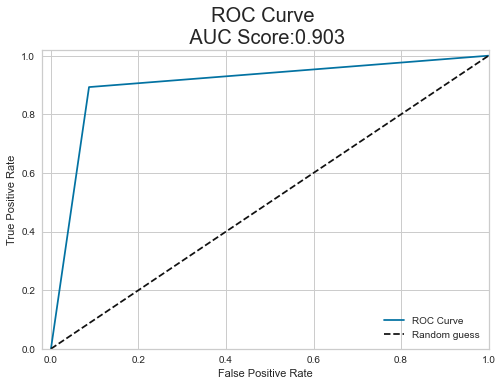

In [210]:

fpr, tpr, thresholds = roc_curve(test_target, preds)

# create plot
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
g = plt.xlabel('False Positive Rate')
g = plt.ylabel('True Positive Rate')
g = plt.title('ROC Curve \n AUC Score:{0:.3f}'.format(roc_auc_score(test_target, preds)), fontsize=20)
g = plt.xlim([-0.02, 1])
g = plt.ylim([0, 1.02])
g = plt.legend(loc="lower right")

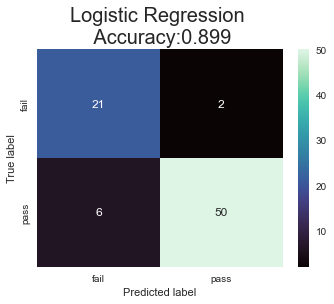

True Negatives:  21
False Positives:  2
False Negatives:  6
True Positives:  50


In [216]:
cm = confusion_matrix(test_target, preds)

cm_df = pd.DataFrame(cm,
                     index = ['fail','pass'],
                     columns = ['fail','pass'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, cmap='mako')
plt.title('Logistic Regression \n Accuracy:{0:.3f}'.format(accuracy_score(test_target, preds)), fontsize=20)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(test_target, preds).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

In [213]:
pd.DataFrame(preds).value_counts()

1    52
0    27
dtype: int64

## B) Modeling After the First Trimester (G1) for Pass/Fail


In [217]:
features = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
           'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
           'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
           'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
           'Walc', 'health', 'absences', 'G1']
target = ['pass']

In [218]:
train_features = train_df[features]
train_target = train_df[target]

test_features = test_df[features]
test_target = test_df[target]

In [219]:
categorical_features_indices = [0, 1, 3, 4, 5, 8, 9, 10, 11]

In [220]:
def objective(trial):

    train_x, valid_x, train_y, valid_y = train_test_split(train_features, train_target, test_size=0.3, stratify=train_df['failures'])

    train_pool = cb.Pool(train_x, train_y, cat_features=categorical_features_indices)
    valid_pool = cb.Pool(valid_x, valid_y, cat_features=categorical_features_indices)

    params = {
        'iterations' : trial.suggest_int('iterations', 50, 300),
        'depth' : trial.suggest_int('depth', 2, 10),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])
    }

    # Conditional Hyper-Parameters
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)
    elif params["bootstrap_type"] == "MVS":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)

    cbclass_model = cb.CatBoostClassifier(**params, random_state=my_seed)

    cb2_optuna = cbclass_model.fit(train_pool, eval_set=valid_pool, verbose=False, early_stopping_rounds=100)

    preds = cb2_optuna.predict(valid_x)

    ROC_AUC_Score = roc_auc_score(valid_y, preds)

    print('ROC AUC Score of CatBoost =', ROC_AUC_Score)

    return ROC_AUC_Score

In [221]:
study = optuna.create_study(direction="maximize", sampler = TPESampler(seed=my_seed), study_name="Trimester 1 Classification")
study.optimize(objective, n_trials=100, n_jobs=-1)

/Users/sam/.conda/envs/env_two/lib/python3.9/site-packages/optuna/study/study.py:393: FutureWarning:

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost = 0.5423076923076923
ROC AUC Score of CatBoost = 0.7238700564971752
ROC AUC Score of CatBoost = 0.5
ROC AUC Score of CatBoost = 0.527027027027027
ROC AUC Score of CatBoost = 0.6693849021435229
ROC AUC Score of CatBoost = 0.7439516129032258


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost = 0.8201754385964913
ROC AUC Score of CatBoost = 0.7629107981220657
ROC AUC Score of CatBoost = 0.5454545454545454


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost = 0.7333829365079365
ROC AUC Score of CatBoost = 0.7913306451612904
ROC AUC Score of CatBoost = 0.695054945054945
ROC AUC Score of CatBoost = 0.7222739981360671


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost = 0.7254464285714286
ROC AUC Score of CatBoost = 0.7444556451612903
ROC AUC Score of CatBoost = 0.6747830279652844


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost = 0.5142857142857142
ROC AUC Score of CatBoost = 0.7200100806451613
ROC AUC Score of CatBoost = ROC AUC Score of CatBoost =0.7339324618736384 0.7569676700111483

ROC AUC Score of CatBoost = 0.7981427174975563
ROC AUC Score of CatBoost =ROC AUC Score of CatBoost = 0.8329133064516129
ROC AUC Score of CatBoost = 0.5718418514946962
 0.7692307692307693


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost =ROC AUC Score of CatBoost = 0.5256410256410257
 0.5
ROC AUC Score of CatBoost = ROC AUC Score of CatBoost = 0.5
0.5206043956043955
ROC AUC Score of CatBoost = 0.5


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost = 0.5441483803552769
ROC AUC Score of CatBoost =ROC AUC Score of CatBoost =ROC AUC Score of CatBoost = 0.7283266129032259
  0.7633442265795207
0.6998587570621468
ROC AUC Score of CatBoost =ROC AUC Score of CatBoost = 0.5
 0.6398809523809523ROC AUC Score of CatBoost =
 0.5185185185185186


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost = 0.7759042033235583
ROC AUC Score of CatBoost = 0.5526315789473684
ROC AUC Score of CatBoost = 0.7745559038662487
ROC AUC Score of CatBoost = 0.7323446327683615
ROC AUC Score of CatBoost =ROC AUC Score of CatBoost = 0.7847985347985347
ROC AUC Score of CatBoost = 0.7607526881720431
 0.8033234126984127
ROC AUC Score of CatBoost = 0.7333333333333334


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost = 0.7721215351812366
ROC AUC Score of CatBoost = 0.8167842741935484ROC AUC Score of CatBoost =
 0.8090386624869383
ROC AUC Score of CatBoost =ROC AUC Score of CatBoost = 0.6304985337243402
 0.8568548387096775
ROC AUC Score of CatBoost = 0.7705128205128204


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost =ROC AUC Score of CatBoost = 0.751806684733514 0.7288306451612904

ROC AUC Score of CatBoost =ROC AUC Score of CatBoost = 0.7800559179869524
 0.7717948717948719
ROC AUC Score of CatBoost = 0.7646588486140725
ROC AUC Score of CatBoost = 0.751828631138976


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost = 0.7725694444444444
ROC AUC Score of CatBoost =ROC AUC Score of CatBoost = 0.7172131147540983
 0.7161016949152542
ROC AUC Score of CatBoost =ROC AUC Score of CatBoost = 0.7415621986499518
 ROC AUC Score of CatBoost =0.8380355276907001
ROC AUC Score of CatBoost =  0.7384615384615384
0.8085824493731918
ROC AUC Score of CatBoost = 0.7296245421245421


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost = 0.7716572504708099
ROC AUC Score of CatBoost = 0.7955641272902604
ROC AUC Score of CatBoost = 0.6192570869990224
ROC AUC Score of CatBoost = 0.7854477611940298
ROC AUC Score of CatBoost = ROC AUC Score of CatBoost =0.7742857142857144
 0.8116197183098591
ROC AUC Score of CatBoost =ROC AUC Score of CatBoost = 0.7474358974358974
 0.7767137096774194


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost = 0.7251984126984127
ROC AUC Score of CatBoost = 0.7531340405014465
ROC AUC Score of CatBoost = 0.7778592375366569
ROC AUC Score of CatBoost = 0.8099999999999999
ROC AUC Score of CatBoost = 0.8528571428571429
ROC AUC Score of CatBoost = 0.8304597701149427
ROC AUC Score of CatBoost = 0.8536168132942327
ROC AUC Score of CatBoost = 0.7238095238095238


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost = 0.7730769230769231
ROC AUC Score of CatBoost = 0.7702380952380952
ROC AUC Score of CatBoost = 0.731191222570533
ROC AUC Score of CatBoost = 0.686950146627566
ROC AUC Score of CatBoost =ROC AUC Score of CatBoost =ROC AUC Score of CatBoost =ROC AUC Score of CatBoost = 0.7560083594566354
 0.8152492668621701
 0.7497519841269842 
0.8510125361620058


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost =ROC AUC Score of CatBoost =ROC AUC Score of CatBoost = 0.7357142857142857
  0.79728317659352140.7416666666666666

ROC AUC Score of CatBoost = 0.7705128205128204
ROC AUC Score of CatBoost =ROC AUC Score of CatBoost = 0.7368421052631579
 0.7523540489642185
ROC AUC Score of CatBoost = 0.7449373191899711
ROC AUC Score of CatBoost = 0.8187382297551788


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC AUC Score of CatBoost = 0.8062072336265885
ROC AUC Score of CatBoost = 0.7809364548494983
ROC AUC Score of CatBoost = 0.74227078891258
ROC AUC Score of CatBoost = 0.7335164835164835


In [222]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.8568548387096775
  Params: 
    iterations: 176
    depth: 7
    learning_rate: 0.15847908151692897
    random_strength: 12
    od_type: Iter
    objective: CrossEntropy
    colsample_bylevel: 0.0564309762756441
    boosting_type: Plain
    bootstrap_type: MVS
    subsample: 0.899870688572485


In [223]:
optuna.visualization.plot_optimization_history(study)

In [224]:
best_model = cb.CatBoostClassifier()
best_model = best_model.set_params(**study.best_params)
best_model = best_model.fit(train_features, train_target, cat_features= categorical_features_indices, verbose=False, early_stopping_rounds=100)

preds = best_model.predict(test_features)

ROC_AUC_Score = roc_auc_score(test_target, preds)

print('ROC AUC Score of CatBoost =', ROC_AUC_Score)

ROC AUC Score of CatBoost = 0.8377329192546584


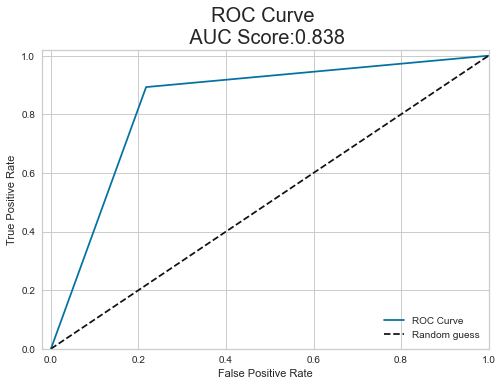

In [225]:

fpr, tpr, thresholds = roc_curve(test_target, preds)

# create plot
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
g = plt.xlabel('False Positive Rate')
g = plt.ylabel('True Positive Rate')
g = plt.title('ROC Curve \n AUC Score:{0:.3f}'.format(roc_auc_score(test_target, preds)), fontsize=20)
g = plt.xlim([-0.02, 1])
g = plt.ylim([0, 1.02])
g = plt.legend(loc="lower right")

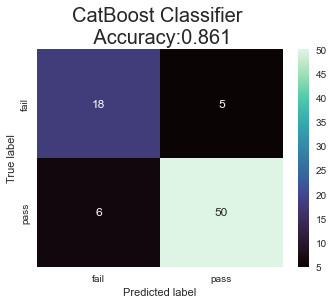

True Negatives:  18
False Positives:  5
False Negatives:  6
True Positives:  50


In [226]:
cm = confusion_matrix(test_target, preds)

cm_df = pd.DataFrame(cm,
                     index = ['fail','pass'],
                     columns = ['fail','pass'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, cmap='mako')
plt.title('CatBoost Classifier \n Accuracy:{0:.3f}'.format(accuracy_score(test_target, preds)), fontsize=20)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(test_target, preds).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

In [227]:
pd.DataFrame(preds).value_counts()

1    55
0    24
dtype: int64

# 3) Multi Classification Modeling (Letter Grade)

## A) Modeling After the Second Trimester (G1, G2) for Letter Grade (A, B, C, D, F)

In [375]:
train_df , test_df = train_test_split(df, test_size=0.2, random_state=my_seed, stratify=df['Grade'])

In [376]:
features = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
           'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
           'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
           'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
           'Walc', 'health', 'absences', 'G1', 'G2']
target = ['Grade']

In [377]:
train_features = train_df[features]
train_target = train_df[target]

test_features = test_df[features]
test_target = test_df[target]

In [378]:
categorical_features_indices = [0, 1, 3, 4, 5, 8, 9, 10, 11]

In [379]:
def objective(trial):

    train_x, valid_x, train_y, valid_y = train_test_split(train_features, train_target, test_size=0.3, stratify=train_df['Grade'])

    train_pool = cb.Pool(train_x, train_y, cat_features=categorical_features_indices)
    valid_pool = cb.Pool(valid_x, valid_y, cat_features=categorical_features_indices)

    classes = np.unique(train_y)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_y.values.reshape(-1))
    class_weights = dict(zip(classes, weights))

    params = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        'iterations' : trial.suggest_int('iterations', 50, 300),
        'depth' : trial.suggest_int('depth', 2, 10),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])
    }

    # Conditional Hyper-Parameters
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)
    elif params["bootstrap_type"] == "MVS":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)

    cbclass_model = cb.CatBoostClassifier(**params, random_state=my_seed,
                                   loss_function='MultiClassOneVsAll', class_weights = class_weights)

    cb2_optuna = cbclass_model.fit(train_pool, eval_set=valid_pool, verbose=False, early_stopping_rounds=100)

    preds = cb2_optuna.predict(valid_x)

    f1score = f1_score(valid_y, preds, average='macro')

    print('F1 Score of CatBoost =', f1score)

    return f1score



    #f05_score = fbeta_score(valid_y, preds, beta=0.5, average='macro')

    #print('F-Beta 0.5 Score of CatBoost =', f05_score)

    #return f05_score

In [380]:
study = optuna.create_study(direction="maximize", sampler = TPESampler(seed=my_seed), study_name="Trimester 2 Multi Classification")
study.optimize(objective, n_trials=100, n_jobs=-1)

/Users/sam/.conda/envs/env_two/lib/python3.9/site-packages/optuna/study/study.py:393: FutureWarning:

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

F1 Score of CatBoost = 0.4198036587068845
F1 Score of CatBoost = 0.5415546772068511
F1 Score of CatBoost = 0.548249450422307
F1 Score of CatBoost = 0.6207864684335272


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

F1 Score of CatBoost = 0.5622164974122162
F1 Score of CatBoost = 0.5335281230943077


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

F1 Score of CatBoost = 0.5423306401739583
F1 Score of CatBoost = 0.558982683982684
F1 Score of CatBoost = 0.6196811473127263
F1 Score of CatBoost = 0.596017316017316


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

F1 Score of CatBoost = 0.6024329112689564
F1 Score of CatBoost =F1 Score of CatBoost = 0.42160412378645196
 0.4902371702371703
F1 Score of CatBoost = 0.6406366862651623


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

F1 Score of CatBoost = 0.5091208791208791
F1 Score of CatBoost = 0.5997292415725595
F1 Score of CatBoost = 0.5822091982091983


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

F1 Score of CatBoost = 0.5385938763037006
F1 Score of CatBoost = 0.6077390308350059


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

F1 Score of CatBoost = 0.5123715816703621
F1 Score of CatBoost = 0.6112033498603372
F1 Score of CatBoost = 0.5355616497458506


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

F1 Score of CatBoost = 0.6329623094297008
F1 Score of CatBoost = 0.6908953475603778
F1 Score of CatBoost = 0.7249231928661861
F1 Score of CatBoost = 0.5489022556390978


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

F1 Score of CatBoost = 0.5318511693511694


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

F1 Score of CatBoost = 0.6173362793166985
F1 Score of CatBoost = 0.6433938526267096
F1 Score of CatBoost = 0.6786981666051435
F1 Score of CatBoost = 0.5995249195249196
F1 Score of CatBoost = 0.6995818281335523
F1 Score of CatBoost = 0.6720279431610702
F1 Score of CatBoost = 0.6308882262582453


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

F1 Score of CatBoost = 0.6539171577215056
F1 Score of CatBoost = 0.7720304232804233
F1 Score of CatBoost = 0.6988176964149504
F1 Score of CatBoost = 0.5910389036251106


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

F1 Score of CatBoost = 0.6822377622377622
F1 Score of CatBoost = 0.6488219691059448
F1 Score of CatBoost = 0.6746666666666667


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

F1 Score of CatBoost = 0.678609654983383
F1 Score of CatBoost = 0.7162858435097241
F1 Score of CatBoost = 0.6053968496962872
F1 Score of CatBoost = 0.6997990659280982
F1 Score of CatBoost = 0.7238660660465971


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

F1 Score of CatBoost = 0.7057173671884629
F1 Score of CatBoost = 0.7477344142785319
F1 Score of CatBoost = 0.7102492102492103
F1 Score of CatBoost = 0.723053287508857
F1 Score of CatBoost = 0.7851626152800135


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

F1 Score of CatBoost = 0.6243356643356643
F1 Score of CatBoost = 0.6889880572910025
F1 Score of CatBoost = F1 Score of CatBoost =0.7104885267189788
 0.6881221344259096


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

F1 Score of CatBoost = 0.6725542797608459
F1 Score of CatBoost = 0.6870811365090541
F1 Score of CatBoost = 0.680445746528606
F1 Score of CatBoost = 0.6993650151668352
F1 Score of CatBoost = 0.7089706897251655


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

F1 Score of CatBoost = 0.6385978970475842
F1 Score of CatBoost = 0.7022286615795743
F1 Score of CatBoost = 0.6029463421053263


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

F1 Score of CatBoost = 0.4865044119354464
F1 Score of CatBoost = 0.6866607700564418
F1 Score of CatBoost = 0.6701307807634644


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

F1 Score of CatBoost = 0.7313973891924712
F1 Score of CatBoost = 0.5737628384687208
F1 Score of CatBoost = 0.7064920575286365
F1 Score of CatBoost = 0.7149905440181937
F1 Score of CatBoost = 0.6550653244806168


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

F1 Score of CatBoost = 0.6417569982611516
F1 Score of CatBoost = F1 Score of CatBoost =0.7482931147987559
 0.7516266720440948


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

F1 Score of CatBoost = 0.7037275985663083
F1 Score of CatBoost = 0.7403837146460097
F1 Score of CatBoost = 0.6437635657462566
F1 Score of CatBoost = 0.734732983366279
F1 Score of CatBoost = 0.6961156876543722


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

F1 Score of CatBoost = 0.6024271541773258
F1 Score of CatBoost = 0.7112410461435948
F1 Score of CatBoost = 0.689590727595386
F1 Score of CatBoost = 0.6096972575004147


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

F1 Score of CatBoost = 0.7288303708580207
F1 Score of CatBoost = 0.6527025173303729
F1 Score of CatBoost = 0.6696383186705768
F1 Score of CatBoost = 0.5828322788322786
F1 Score of CatBoost = 0.5855649237911619
F1 Score of CatBoost = 0.664937417654809
F1 Score of CatBoost = 0.7476678876678877
F1 Score of CatBoost = 0.7485985687237252


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

F1 Score of CatBoost = 0.7396224146224147
F1 Score of CatBoost = 0.6956478578892372
F1 Score of CatBoost = 0.6153232323232324
F1 Score of CatBoost = 0.741408906623079
F1 Score of CatBoost = 0.6677097505668934
F1 Score of CatBoost = 0.698473697430458
F1 Score of CatBoost = 0.672873531697061
F1 Score of CatBoost = 0.6605351155110937
F1 Score of CatBoost = 0.7092253455984378


In [381]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.7851626152800135
  Params: 
    iterations: 299
    depth: 6
    learning_rate: 0.05022728869631353
    random_strength: 91
    od_type: IncToDec
    colsample_bylevel: 0.09219955563500674
    boosting_type: Ordered
    bootstrap_type: MVS
    subsample: 0.5980413121795455


In [383]:
optuna.visualization.plot_optimization_history(study)

In [384]:
classes = np.unique(train_target)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_target.values.reshape(-1))
class_weights = dict(zip(classes, weights))

best_model = cb.CatBoostClassifier(loss_function='MultiClassOneVsAll', class_weights = class_weights)
best_model = best_model.set_params(**study.best_params)
best_model = best_model.fit(train_features, train_target, cat_features= categorical_features_indices, verbose=False, early_stopping_rounds=100)

preds = best_model.predict(test_features)

f1score = f1_score(test_target, preds, average='macro')

print('F1 Score of CatBoost =', f1score)


F1 Score of CatBoost = 0.5898567119155355


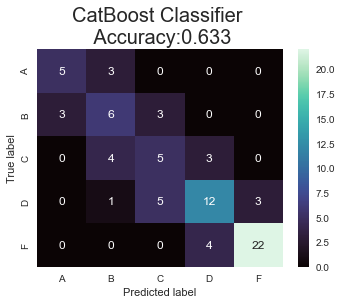

In [385]:
cm = confusion_matrix(test_target, preds)


cm_df = pd.DataFrame(cm,
                     index = ['A','B','C','D','F'],
                     columns = ['A','B','C','D','F'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, cmap='mako')
plt.title('CatBoost Classifier \n Accuracy:{0:.3f}'.format(accuracy_score(test_target, preds)), fontsize=20)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [338]:
pd.DataFrame(preds).value_counts()

F    26
D    18
C    14
B    13
A     8
dtype: int64

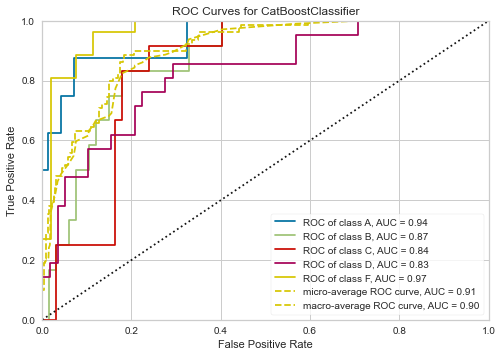

<AxesSubplot:title={'center':'ROC Curves for CatBoostClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [372]:
yellowbrick_model = wrap(best_model)
visualizer = ROCAUC(yellowbrick_model)
visualizer.fit(train_features, train_target)
visualizer.score(test_features, test_target)
visualizer.show()

In [489]:
from catboost import cv

In [511]:
train_df , test_df = train_test_split(df, test_size=0.2, random_state=my_seed, stratify=df['Grade'])

In [512]:
features = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
           'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
           'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
           'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
           'Walc', 'health', 'absences', 'G1', 'G2']
target = ['Grade']

In [513]:
train_features = train_df[features]
train_target = train_df[target]

test_features = test_df[features]
test_target = test_df[target]

In [514]:
categorical_features_indices = [0, 1, 3, 4, 5, 8, 9, 10, 11]

In [515]:
from sklearn.model_selection import StratifiedKFold

In [516]:
def objective(trial):

    classes = np.unique(train_target)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y = train_target.values.reshape(-1))
    class_weights = dict(zip(classes, weights))

    params = {
        'iterations' : trial.suggest_int('iterations', 50, 300),
        'depth' : trial.suggest_int('depth', 2, 10),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),

    }

    # Conditional Hyper-Parameters
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)
    elif params["bootstrap_type"] == "MVS":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)

    skf = StratifiedKFold(n_splits=5, random_state=my_seed, shuffle=True)

    cv_scores = []

    for train_index, test_index in skf.split(train_features,train_target):

        X_train, X_valid = train_features.iloc[train_index], train_features.iloc[test_index]
        y_train, y_valid = train_target.iloc[train_index], train_target.iloc[test_index]

        cbmulticlass_model = cb.CatBoostClassifier(**params, random_state=my_seed,
                                loss_function='MultiClassOneVsAll', class_weights = class_weights)

        cbmulticlass_model.fit(X_train, y_train, cat_features=categorical_features_indices,eval_set=[(X_valid, y_valid)], verbose=False)

        preds = cbmulticlass_model.predict(X_valid)

        score = f1_score(preds, y_valid, average='macro')

        cv_scores.append(score)

    cv_avg_score = np.mean(cv_scores)

    print('CV Avg F1 Score of CatBoost =', cv_avg_score)

    return cv_avg_score


In [517]:
train_features.shape

(316, 32)

In [518]:

study = optuna.create_study(direction="maximize", sampler = TPESampler(seed=my_seed), study_name="Trimester 2 Multi Classification")
study.optimize(objective, n_trials=100, n_jobs=-1)


/Users/sam/.conda/envs/env_two/lib/python3.9/site-packages/optuna/study/study.py:393: FutureWarning:

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at sam

CV Avg F1 Score of CatBoost = 0.6001417396158641
CV Avg F1 Score of CatBoost = 0.5078610889399127


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

CV Avg F1 Score of CatBoost = 0.7035010376620283


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

CV Avg F1 Score of CatBoost = 0.4685765373680974
CV Avg F1 Score of CatBoost = 0.6150676110118026


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

CV Avg F1 Score of CatBoost = 0.5326417477081112
CV Avg F1 Score of CatBoost = 0.524932746778862
CV Avg F1 Score of CatBoost = 0.6159871055468404


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

CV Avg F1 Score of CatBoost = 0.583470801822996
CV Avg F1 Score of CatBoost =CV Avg F1 Score of CatBoost =  0.53991448730400340.6598660384816345



Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

CV Avg F1 Score of CatBoost = 0.5894782682620708
CV Avg F1 Score of CatBoost = 0.5928651023404707
CV Avg F1 Score of CatBoost = 0.6700029630442168
CV Avg F1 Score of CatBoost = 0.6659519272931936
CV Avg F1 Score of CatBoost = 0.6858367679056085


KeyboardInterrupt: 

In [506]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.7389993158022948
  Params: 
    iterations: 292
    depth: 8
    learning_rate: 0.28867450646041054
    random_strength: 72
    od_type: IncToDec
    colsample_bylevel: 0.08931377168116722
    boosting_type: Ordered
    bootstrap_type: MVS
    subsample: 0.603934415620123


In [507]:
optuna.visualization.plot_optimization_history(study)

In [508]:
classes = np.unique(train_target)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_target.values.reshape(-1))
class_weights = dict(zip(classes, weights))

best_model = cb.CatBoostClassifier(loss_function='MultiClassOneVsAll', class_weights = class_weights)
best_model = best_model.set_params(**study.best_params)
best_model = best_model.fit(train_features, train_target, cat_features= categorical_features_indices, verbose=False, early_stopping_rounds=100)

preds = best_model.predict(test_features)

f1score = f1_score(test_target, preds, average='macro')

print('F1 Score of CatBoost =', f1score)

F1 Score of CatBoost = 0.6598386779460949


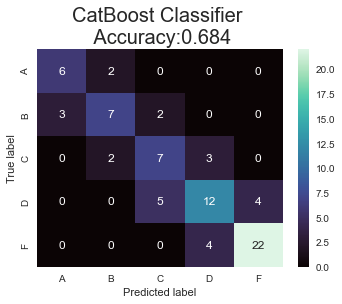

In [509]:
cm = confusion_matrix(test_target, preds)


cm_df = pd.DataFrame(cm,
                     index = ['A','B','C','D','F'],
                     columns = ['A','B','C','D','F'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, cmap='mako')
plt.title('CatBoost Classifier \n Accuracy:{0:.3f}'.format(accuracy_score(test_target, preds)), fontsize=20)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

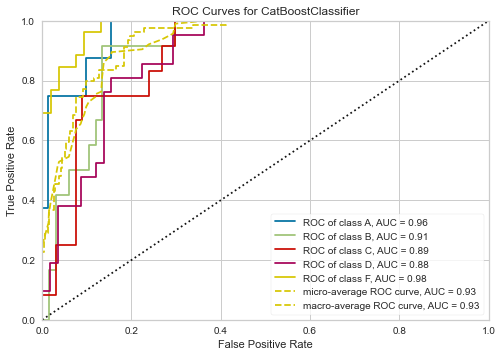

<AxesSubplot:title={'center':'ROC Curves for CatBoostClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [510]:
yellowbrick_model = wrap(best_model)
visualizer = ROCAUC(yellowbrick_model)
visualizer.fit(train_features, train_target)
visualizer.score(test_features, test_target)
visualizer.show()

In [ ]:
use_best_model=True,